Dataset training: 100 validation: 20


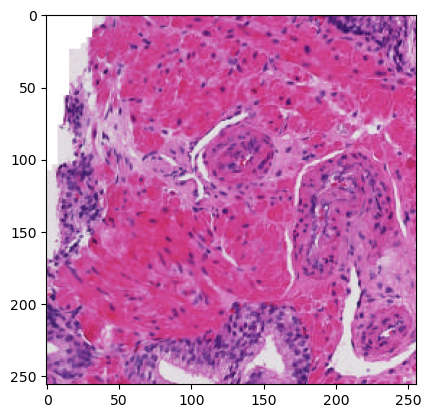

In [1]:
import torch
import numpy as np
from monai.data import Dataset, load_decathlon_datalist
from monai.data.wsi_reader import WSIReader
from monai.config import KeysCollection
from monai.transforms import (
    Compose,
    GridPatchd,
    LoadImaged,
    MapTransform,
    RandFlipd,
    RandGridPatchd,
    RandRotate90d,
    ScaleIntensityRanged,
    SplitDimd,
    ToTensord,
)

from matplotlib import pyplot as plt

class LabelEncodeIntegerGraded(MapTransform):
    """
    Convert an integer label to encoded array representation of length num_classes,
    with 1 filled in up to label index, and 0 otherwise. For example for num_classes=5,
    embedding of 2 -> (1,1,0,0,0)

    Args:
        num_classes: the number of classes to convert to encoded format.
        keys: keys of the corresponding items to be transformed. Defaults to ``'label'``.
        allow_missing_keys: don't raise exception if key is missing.

    """

    def __init__(
        self,
        num_classes: int,
        keys: KeysCollection = "label",
        allow_missing_keys: bool = False,
    ):
        super().__init__(keys, allow_missing_keys)
        self.num_classes = num_classes

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label = int(d[key])

            lz = np.zeros(self.num_classes, dtype=np.float32)
            lz[:label] = 1.0
            # alternative oneliner lz=(np.arange(self.num_classes)<int(label)).astype(np.float32) #same oneliner
            d[key] = lz

        return d

torch.cuda.set_device("cuda:0")  
torch.backends.cudnn.benchmark = True

training_list = load_decathlon_datalist(
        data_list_file_path="/datasets/AZ_Workshop/datalist_panda_0.json",
        data_list_key="training",
        base_dir="/Panda/train_images"
    )

validation_list = load_decathlon_datalist(
        data_list_file_path="/datasets/AZ_Workshop/datalist_panda_0.json",
        data_list_key="validation",
        base_dir="/Panda/train_images",
    )

train_transform = Compose(
        [
            LoadImaged(keys=["image"], reader=WSIReader, backend="cucim", dtype=np.uint8, level=1, image_only=True),
            LabelEncodeIntegerGraded(keys=["label"], num_classes=5),
            RandGridPatchd(
                keys=["image"],
                patch_size=(256, 256),
                num_patches=44,
                sort_fn="min",
                pad_mode=None,
                constant_values=255,
            ),
            SplitDimd(keys=["image"], dim=0, keepdim=False, list_output=True),
            RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
            RandFlipd(keys=["image"], spatial_axis=1, prob=0.5),
            RandRotate90d(keys=["image"], prob=0.5),
            ScaleIntensityRanged(keys=["image"], a_min=np.float32(0), a_max=np.float32(255)),
            ToTensord(keys=["image", "label"]),
        ]
    )

valid_transform = Compose(
        [
            LoadImaged(keys=["image"], reader=WSIReader, backend="cucim", dtype=np.uint8, level=1, image_only=True),
            LabelEncodeIntegerGraded(keys=["label"], num_classes=5),
            GridPatchd(
                keys=["image"],
                patch_size=(256, 256),
                threshold=0.999 * 3 * 255 * 256 * 256,
                pad_mode=None,
                constant_values=255,
            ),
            SplitDimd(keys=["image"], dim=0, keepdim=False, list_output=True),
            ScaleIntensityRanged(keys=["image"], a_min=np.float32(0), a_max=np.float32(255)),
            ToTensord(keys=["image", "label"]),
        ]
    )

dataset_train = Dataset(data=training_list, transform=train_transform)
dataset_valid = Dataset(data=validation_list, transform=valid_transform)

print("Dataset training:", len(dataset_train), "validation:", len(dataset_valid))

im = np.moveaxis(dataset_train[0][0]["image"].cpu(),0,-1)
plt.imshow(im)


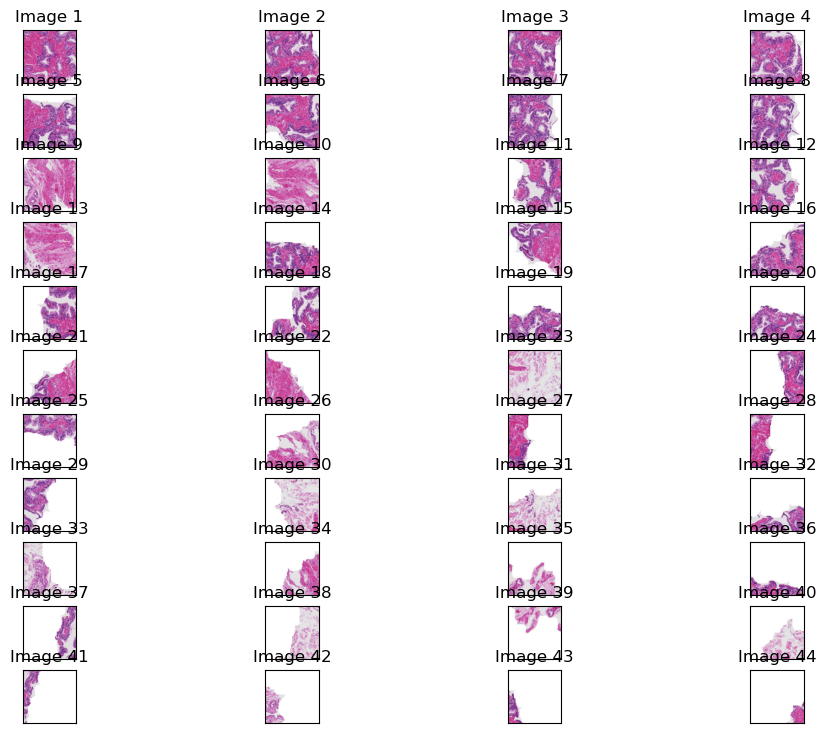

In [26]:
fig, axes = plt.subplots(11, 4, figsize=(12, 9))

for i, ax in enumerate(axes.flat):
    if i < len(dataset_train[0]):
        # Display the image
        ax.imshow(np.moveaxis(dataset_train[0][i]["image"].cpu(),0,-1))
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Optionally, add a title or label for each image
        ax.set_title(f"Image {i+1}")
    else:
        # If there are fewer images than subplots, remove extra subplots
        ax.remove()

In [2]:
import collections.abc
from torch.utils.data.dataloader import default_collate

def list_data_collate(batch: collections.abc.Sequence):
    """
    Combine instances from a list of dicts into a single dict, by stacking them along first dim
    [{'image' : 3xHxW}, {'image' : 3xHxW}, {'image' : 3xHxW}...] - > {'image' : Nx3xHxW}
    followed by the default collate which will form a batch BxNx3xHxW
    """

    for i, item in enumerate(batch):
        # print(f"{i} = {item['image'].shape=} >> {item['image'].keys=}")
        data = item[0]
        data["image"] = torch.stack([ix["image"] for ix in item], dim=0)
        # data["patch_location"] = torch.stack([ix["patch_location"] for ix in item], dim=0)
        batch[i] = data
    return default_collate(batch)


train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=list_data_collate,
)
valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=list_data_collate,
)

print("Dataset training:", len(dataset_train), "validation:", len(dataset_valid))

    #


Dataset training: 100 validation: 20


In [3]:
from monai.networks.nets import milmodel
import os

model = milmodel.MILModel(num_classes=5, pretrained=True, mil_mode="att_trans")

best_acc = 0
start_epoch = 0
checkpoint_path = "/datasets/AZ_Workshop/mil_checkpoint.pt"

# load a checkpoint if one is supplied
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(checkpoint["state_dict"])
    if "epoch" in checkpoint:
        start_epoch = checkpoint["epoch"]
    if "best_acc" in checkpoint:
        best_acc = checkpoint["best_acc"]
    print("=> loaded checkpoint '{}' (epoch {}) (bestacc {})".format(args.checkpoint, start_epoch, best_acc))

model.cuda("cuda:0")

params = model.parameters()

m = model 
params = [
    {"params": list(m.attention.parameters()) + list(m.myfc.parameters()) + list(m.net.parameters())},
    {"params": list(m.transformer.parameters()), "lr": 6e-6, "weight_decay": 0.1},
]

optimizer = torch.optim.AdamW(params, lr=3e-5, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)


/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_pa

In [4]:
import torch.nn as nn
from monai.metrics import Cumulative, CumulativeAverage
from torch.cuda.amp import GradScaler, autocast
import time

model.train()
criterion = nn.BCEWithLogitsLoss()

scaler = GradScaler(enabled=True)

run_loss = CumulativeAverage()
run_acc = CumulativeAverage()

start_time = time.time()
loss, acc = 0.0, 0.0

for idx, batch_data in enumerate(train_loader):
    data = batch_data["image"].as_subclass(torch.Tensor).cuda(0)
    target = batch_data["label"].as_subclass(torch.Tensor).cuda(0)

    optimizer.zero_grad(set_to_none=True)

    with autocast(enabled=True):
        logits = model(data)
        loss = criterion(logits, target)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    acc = (logits.sigmoid().sum(1).detach().round() == target.sum(1).round()).float().mean()

    run_loss.append(loss)
    run_acc.append(acc)

    loss = run_loss.aggregate()
    acc = run_acc.aggregate()

    print(
        "loss: {:.4f}".format(loss),
        "acc: {:.4f}".format(acc),
        "time {:.2f}s".format(time.time() - start_time),
        )



/tmp/ipykernel_5704/3590457571.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
/tmp/ipykernel_5704/3590457571.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


loss: 0.7211 acc: 0.0000 time 16.65s
loss: 0.6380 acc: 0.0000 time 19.75s
loss: 0.6872 acc: 0.0000 time 23.29s
loss: 0.6506 acc: 0.0625 time 30.68s
loss: 0.6258 acc: 0.0750 time 36.74s
loss: 0.5954 acc: 0.0833 time 43.51s
loss: 0.5765 acc: 0.1071 time 49.40s
loss: 0.5512 acc: 0.1562 time 56.94s
loss: 0.5487 acc: 0.1389 time 63.98s
loss: 0.5860 acc: 0.1375 time 69.59s
loss: 0.5854 acc: 0.1364 time 73.84s
loss: 0.5740 acc: 0.1667 time 80.33s
loss: 0.5600 acc: 0.1538 time 86.34s


In [5]:
def train_epoch(model, loader, optimizer, scaler, epoch, epochs):

    model.train()
    criterion = nn.BCEWithLogitsLoss()

    run_loss = CumulativeAverage()
    run_acc = CumulativeAverage()

    start_time = time.time()
    loss, acc = 0.0, 0.0

    for idx, batch_data in enumerate(loader):
        data = batch_data["image"].as_subclass(torch.Tensor).cuda(0)
        target = batch_data["label"].as_subclass(torch.Tensor).cuda(0)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            logits = model(data)
            loss = criterion(logits, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = (logits.sigmoid().sum(1).detach().round() == target.sum(1).round()).float().mean()

        run_loss.append(loss)
        run_acc.append(acc)

        loss = run_loss.aggregate()
        acc = run_acc.aggregate()

        print(
            "Epoch {}/{} {}/{}".format(epoch, epochs, idx, len(loader)),
            "loss: {:.4f}".format(loss),
            "acc: {:.4f}".format(acc),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()

    return loss, acc

In [6]:
def save_checkpoint(model, epoch, filename="model.pt", best_acc=0):
    """Save checkpoint"""

    state_dict = model.state_dict()

    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}

    filename = os.path.join(args.logdir, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [9]:
from sklearn.metrics import cohen_kappa_score

def val_epoch(model, loader, epoch, epochs, max_tiles=None):
    """One validation epoch over the dataset"""

    model.eval()

    model2 = model
    extra_outputs = model2.extra_outputs
    calc_head = model2.calc_head

    criterion = nn.BCEWithLogitsLoss()

    run_loss = CumulativeAverage()
    run_acc = CumulativeAverage()
    PREDS = Cumulative()
    TARGETS = Cumulative()

    start_time = time.time()
    loss, acc = 0.0, 0.0

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data = batch_data["image"].as_subclass(torch.Tensor).cuda(0)
            target = batch_data["label"].as_subclass(torch.Tensor).cuda(0)

            with autocast(enabled=True):
                if max_tiles is not None and data.shape[1] > max_tiles:
                    # During validation, we want to use all instances/patches
                    # and if its number is very big, we may run out of GPU memory
                    # in this case, we first iteratively go over subsets of patches to calculate backbone features
                    # and at the very end calculate the classification output

                    logits = []
                    logits2 = []

                    for i in range(int(np.ceil(data.shape[1] / float(max_tiles)))):
                        data_slice = data[:, i * max_tiles : (i + 1) * max_tiles]
                        logits_slice = model(data_slice, no_head=True)
                        logits.append(logits_slice)

                    logits = torch.cat(logits, dim=1)
                    logits = calc_head(logits)

                else:
                    # if number of instances is not big, we can run inference directly
                    logits = model(data)

                loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            target = target.sum(1).round()
            acc = (pred == target).float().mean()

            run_loss.append(loss)
            run_acc.append(acc)
            loss = run_loss.aggregate()
            acc = run_acc.aggregate()

            PREDS.extend(pred)
            TARGETS.extend(target)

            print(
                "Val epoch {}/{} {}/{}".format(epoch, epochs, idx, len(loader)),
                "loss: {:.4f}".format(loss),
                "acc: {:.4f}".format(acc),
                "time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

        # Calculate QWK metric (Quadratic Weigted Kappa) https://en.wikipedia.org/wiki/Cohen%27s_kappa
        PREDS = PREDS.get_buffer().cpu().numpy()
        TARGETS = TARGETS.get_buffer().cpu().numpy()
        qwk = cohen_kappa_score(PREDS.astype(np.float64), TARGETS.astype(np.float64), weights="quadratic")

    return loss, acc, qwk

In [ ]:
# RUN TRAINING
n_epochs = 20
val_acc_max = 0.0
val_every_n_epochs=5

scaler = GradScaler(enabled=True)

for epoch in range(start_epoch, n_epochs):

    print(time.ctime(), "Epoch:", epoch)

    epoch_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler=scaler, epoch=epoch, epochs=n_epochs)

    print(
        "Final training  {}/{}".format(epoch, n_epochs - 1),
        "loss: {:.4f}".format(train_loss),
        "acc: {:.4f}".format(train_acc),
        "time {:.2f}s".format(time.time() - epoch_time),
    )

    b_new_best = False
    val_acc = 0
    if (epoch + 1) % val_every_n_epochs == 0:
        epoch_time = time.time()
        val_loss, val_acc, qwk = val_epoch(model, valid_loader, epoch=epoch, epochs=n_epochs, max_tiles=44)
        print(
            "Final validation  {}/{}".format(epoch, n_epochs - 1),
            "loss: {:.4f}".format(val_loss),
            "acc: {:.4f}".format(val_acc),
            "qwk: {:.4f}".format(qwk),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        val_acc = qwk

        if val_acc > val_acc_max:
            print("qwk ({:.6f} --> {:.6f})".format(val_acc_max, val_acc))
            val_acc_max = val_acc
            b_new_best = True
        
        if b_new_best:
            print("Saving new best model!!!!")
            save_checkpoint(model, epoch, args, best_acc=val_acc, filename="/datasets/AZ_Workshop/model_best.pt")

    scheduler.step()

print("ALL DONE")

Wed Feb  5 19:12:13 2025 Epoch: 0


/tmp/ipykernel_5704/333877950.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
/tmp/ipykernel_5704/74706458.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 0/20 0/13 loss: 0.0351 acc: 1.0000 time 12.64s
Epoch 0/20 1/13 loss: 0.0360 acc: 1.0000 time 7.88s
Epoch 0/20 2/13 loss: 0.0311 acc: 1.0000 time 3.85s
Epoch 0/20 3/13 loss: 0.0305 acc: 1.0000 time 7.54s
Epoch 0/20 4/13 loss: 0.0294 acc: 1.0000 time 6.46s
Epoch 0/20 5/13 loss: 0.0290 acc: 1.0000 time 6.90s
Epoch 0/20 6/13 loss: 0.0326 acc: 0.9821 time 5.80s
Epoch 0/20 7/13 loss: 0.0346 acc: 0.9844 time 7.58s
Epoch 0/20 8/13 loss: 0.0336 acc: 0.9861 time 7.07s
Epoch 0/20 9/13 loss: 0.0331 acc: 0.9875 time 5.68s
Epoch 0/20 10/13 loss: 0.0325 acc: 0.9886 time 4.48s
Epoch 0/20 11/13 loss: 0.0319 acc: 0.9896 time 6.68s
Epoch 0/20 12/13 loss: 0.0312 acc: 0.9904 time 3.78s
Final training  0/19 loss: 0.0312 acc: 0.9904 time 86.50s
Wed Feb  5 19:13:39 2025 Epoch: 1
Epoch 1/20 0/13 loss: 0.0216 acc: 1.0000 time 12.39s
Epoch 1/20 1/13 loss: 0.0427 acc: 0.9375 time 7.19s
Epoch 1/20 2/13 loss: 0.0365 acc: 0.9583 time 3.73s
Epoch 1/20 3/13 loss: 0.0377 acc: 0.9688 time 7.07s
Epoch 1/20 4/13 los

/tmp/ipykernel_5704/3176433251.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Val epoch 4/20 0/20 loss: 0.0174 acc: 1.0000 time 0.84s
Val epoch 4/20 1/20 loss: 0.0202 acc: 1.0000 time 0.38s
Val epoch 4/20 2/20 loss: 0.3741 acc: 0.6667 time 0.05s
Val epoch 4/20 3/20 loss: 1.1167 acc: 0.5000 time 0.80s
Val epoch 4/20 4/20 loss: 0.8977 acc: 0.6000 time 1.24s
Val epoch 4/20 5/20 loss: 0.7641 acc: 0.6667 time 0.43s
Val epoch 4/20 6/20 loss: 0.7512 acc: 0.5714 time 1.47s
Val epoch 4/20 7/20 loss: 0.6582 acc: 0.6250 time 0.44s
Val epoch 4/20 8/20 loss: 0.6113 acc: 0.5556 time 1.04s
Val epoch 4/20 9/20 loss: 0.6024 acc: 0.5000 time 0.02s
Val epoch 4/20 10/20 loss: 0.5610 acc: 0.4545 time 0.60s
Val epoch 4/20 11/20 loss: 0.5160 acc: 0.5000 time 1.04s
Val epoch 4/20 12/20 loss: 0.5243 acc: 0.4615 time 1.01s
Val epoch 4/20 13/20 loss: 0.4986 acc: 0.4286 time 0.61s
Val epoch 4/20 14/20 loss: 0.4902 acc: 0.4667 time 0.86s
Val epoch 4/20 15/20 loss: 0.4783 acc: 0.4375 time 0.72s
Val epoch 4/20 16/20 loss: 0.5953 acc: 0.4118 time 0.62s
Val epoch 4/20 17/20 loss: 0.5628 acc: 0.

In [45]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import collections.abc
import os
import shutil
import time

import gdown
import numpy as np
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
from monai.config import KeysCollection
from monai.data import Dataset, load_decathlon_datalist
from monai.data.wsi_reader import WSIReader
from monai.metrics import Cumulative, CumulativeAverage
from monai.networks.nets import milmodel
from monai.transforms import (
    Compose,
    GridPatchd,
    LoadImaged,
    MapTransform,
    RandFlipd,
    RandGridPatchd,
    RandRotate90d,
    ScaleIntensityRanged,
    SplitDimd,
    ToTensord,
)
from sklearn.metrics import cohen_kappa_score
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data.dataloader import default_collate
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter


def train_epoch(model, loader, optimizer, scaler, epoch, args):
    """One train epoch over the dataset"""

    model.train()
    criterion = nn.BCEWithLogitsLoss()

    run_loss = CumulativeAverage()
    run_acc = CumulativeAverage()

    start_time = time.time()
    loss, acc = 0.0, 0.0

    for idx, batch_data in enumerate(loader):
        data = batch_data["image"].as_subclass(torch.Tensor).cuda(args.rank)
        target = batch_data["label"].as_subclass(torch.Tensor).cuda(args.rank)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=args.amp):
            logits = model(data)
            loss = criterion(logits, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = (logits.sigmoid().sum(1).detach().round() == target.sum(1).round()).float().mean()

        run_loss.append(loss)
        run_acc.append(acc)

        loss = run_loss.aggregate()
        acc = run_acc.aggregate()

        if args.rank == 0:
            print(
                "Epoch {}/{} {}/{}".format(epoch, args.epochs, idx, len(loader)),
                "loss: {:.4f}".format(loss),
                "acc: {:.4f}".format(acc),
                "time {:.2f}s".format(time.time() - start_time),
            )
        start_time = time.time()

    return loss, acc


def val_epoch(model, loader, epoch, args, max_tiles=None):
    """One validation epoch over the dataset"""

    model.eval()

    model2 = model if not args.distributed else model.module
    has_extra_outputs = model2.mil_mode == "att_trans_pyramid"
    extra_outputs = model2.extra_outputs
    calc_head = model2.calc_head

    criterion = nn.BCEWithLogitsLoss()

    run_loss = CumulativeAverage()
    run_acc = CumulativeAverage()
    PREDS = Cumulative()
    TARGETS = Cumulative()

    start_time = time.time()
    loss, acc = 0.0, 0.0

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data = batch_data["image"].as_subclass(torch.Tensor).cuda(args.rank)
            target = batch_data["label"].as_subclass(torch.Tensor).cuda(args.rank)

            with autocast(enabled=args.amp):
                if max_tiles is not None and data.shape[1] > max_tiles:
                    # During validation, we want to use all instances/patches
                    # and if its number is very big, we may run out of GPU memory
                    # in this case, we first iteratively go over subsets of patches to calculate backbone features
                    # and at the very end calculate the classification output

                    logits = []
                    logits2 = []

                    for i in range(int(np.ceil(data.shape[1] / float(max_tiles)))):
                        data_slice = data[:, i * max_tiles : (i + 1) * max_tiles]
                        logits_slice = model(data_slice, no_head=True)
                        logits.append(logits_slice)

                        if has_extra_outputs:
                            logits2.append(
                                [
                                    extra_outputs["layer1"],
                                    extra_outputs["layer2"],
                                    extra_outputs["layer3"],
                                    extra_outputs["layer4"],
                                ]
                            )

                    logits = torch.cat(logits, dim=1)
                    if has_extra_outputs:
                        extra_outputs["layer1"] = torch.cat([l[0] for l in logits2], dim=0)
                        extra_outputs["layer2"] = torch.cat([l[1] for l in logits2], dim=0)
                        extra_outputs["layer3"] = torch.cat([l[2] for l in logits2], dim=0)
                        extra_outputs["layer4"] = torch.cat([l[3] for l in logits2], dim=0)

                    logits = calc_head(logits)

                else:
                    # if number of instances is not big, we can run inference directly
                    logits = model(data)

                loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            target = target.sum(1).round()
            acc = (pred == target).float().mean()

            run_loss.append(loss)
            run_acc.append(acc)
            loss = run_loss.aggregate()
            acc = run_acc.aggregate()

            PREDS.extend(pred)
            TARGETS.extend(target)

            if args.rank == 0:
                print(
                    "Val epoch {}/{} {}/{}".format(epoch, args.epochs, idx, len(loader)),
                    "loss: {:.4f}".format(loss),
                    "acc: {:.4f}".format(acc),
                    "time {:.2f}s".format(time.time() - start_time),
                )
            start_time = time.time()

        # Calculate QWK metric (Quadratic Weigted Kappa) https://en.wikipedia.org/wiki/Cohen%27s_kappa
        PREDS = PREDS.get_buffer().cpu().numpy()
        TARGETS = TARGETS.get_buffer().cpu().numpy()
        qwk = cohen_kappa_score(PREDS.astype(np.float64), TARGETS.astype(np.float64), weights="quadratic")

    return loss, acc, qwk


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0):
    """Save checkpoint"""

    state_dict = model.state_dict()

    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}

    filename = os.path.join(args.logdir, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)


class LabelEncodeIntegerGraded(MapTransform):
    """
    Convert an integer label to encoded array representation of length num_classes,
    with 1 filled in up to label index, and 0 otherwise. For example for num_classes=5,
    embedding of 2 -> (1,1,0,0,0)

    Args:
        num_classes: the number of classes to convert to encoded format.
        keys: keys of the corresponding items to be transformed. Defaults to ``'label'``.
        allow_missing_keys: don't raise exception if key is missing.

    """

    def __init__(
        self,
        num_classes: int,
        keys: KeysCollection = "label",
        allow_missing_keys: bool = False,
    ):
        super().__init__(keys, allow_missing_keys)
        self.num_classes = num_classes

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label = int(d[key])

            lz = np.zeros(self.num_classes, dtype=np.float32)
            lz[:label] = 1.0
            # alternative oneliner lz=(np.arange(self.num_classes)<int(label)).astype(np.float32) #same oneliner
            d[key] = lz

        return d


def list_data_collate(batch: collections.abc.Sequence):
    """
    Combine instances from a list of dicts into a single dict, by stacking them along first dim
    [{'image' : 3xHxW}, {'image' : 3xHxW}, {'image' : 3xHxW}...] - > {'image' : Nx3xHxW}
    followed by the default collate which will form a batch BxNx3xHxW
    """

    for i, item in enumerate(batch):
        # print(f"{i} = {item['image'].shape=} >> {item['image'].keys=}")
        data = item[0]
        data["image"] = torch.stack([ix["image"] for ix in item], dim=0)
        # data["patch_location"] = torch.stack([ix["patch_location"] for ix in item], dim=0)
        batch[i] = data
    return default_collate(batch)


def main_worker(gpu, args):
    args.gpu = gpu

    if args.distributed:
        args.rank = args.rank * torch.cuda.device_count() + gpu
        dist.init_process_group(
            backend=args.dist_backend, init_method=args.dist_url, world_size=args.world_size, rank=args.rank
        )

    print(args.rank, " gpu", args.gpu)

    torch.cuda.set_device(args.gpu)  # use this default device (same as args.device if not distributed)
    torch.backends.cudnn.benchmark = True

    if args.rank == 0:
        print("Batch size is:", args.batch_size, "epochs", args.epochs)

    #############
    # Create MONAI dataset
    training_list = load_decathlon_datalist(
        data_list_file_path=args.dataset_json,
        data_list_key="training",
        base_dir=args.data_root,
    )
    validation_list = load_decathlon_datalist(
        data_list_file_path=args.dataset_json,
        data_list_key="validation",
        base_dir=args.data_root,
    )

    if args.quick:  # for debugging on a small subset
        training_list = training_list[:16]
        validation_list = validation_list[:16]

    train_transform = Compose(
        [
            LoadImaged(keys=["image"], reader=WSIReader, backend="cucim", dtype=np.uint8, level=1, image_only=True),
            LabelEncodeIntegerGraded(keys=["label"], num_classes=args.num_classes),
            RandGridPatchd(
                keys=["image"],
                patch_size=(args.tile_size, args.tile_size),
                num_patches=args.tile_count,
                sort_fn="min",
                pad_mode=None,
                constant_values=255,
            ),
            SplitDimd(keys=["image"], dim=0, keepdim=False, list_output=True),
            RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
            RandFlipd(keys=["image"], spatial_axis=1, prob=0.5),
            RandRotate90d(keys=["image"], prob=0.5),
            ScaleIntensityRanged(keys=["image"], a_min=np.float32(0), a_max=np.float32(255)),
            ToTensord(keys=["image", "label"]),
        ]
    )

    valid_transform = Compose(
        [
            LoadImaged(keys=["image"], reader=WSIReader, backend="cucim", dtype=np.uint8, level=1, image_only=True),
            LabelEncodeIntegerGraded(keys=["label"], num_classes=args.num_classes),
            GridPatchd(
                keys=["image"],
                patch_size=(args.tile_size, args.tile_size),
                threshold=0.999 * 3 * 255 * args.tile_size * args.tile_size,
                pad_mode=None,
                constant_values=255,
            ),
            SplitDimd(keys=["image"], dim=0, keepdim=False, list_output=True),
            ScaleIntensityRanged(keys=["image"], a_min=np.float32(0), a_max=np.float32(255)),
            ToTensord(keys=["image", "label"]),
        ]
    )

    dataset_train = Dataset(data=training_list, transform=train_transform)
    dataset_valid = Dataset(data=validation_list, transform=valid_transform)

    train_sampler = DistributedSampler(dataset_train) if args.distributed else None
    val_sampler = DistributedSampler(dataset_valid, shuffle=False) if args.distributed else None

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=(train_sampler is None),
        num_workers=args.workers,
        pin_memory=True,
        multiprocessing_context="spawn" if args.workers > 0 else None,
        sampler=train_sampler,
        collate_fn=list_data_collate,
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=1,
        shuffle=False,
        num_workers=args.workers,
        pin_memory=True,
        multiprocessing_context="spawn" if args.workers > 0 else None,
        sampler=val_sampler,
        collate_fn=list_data_collate,
    )

    if args.rank == 0:
        print("Dataset training:", len(dataset_train), "validation:", len(dataset_valid))

    model = milmodel.MILModel(num_classes=args.num_classes, pretrained=True, mil_mode=args.mil_mode)

    best_acc = 0
    start_epoch = 0
    if args.checkpoint is not None:
        checkpoint = torch.load(args.checkpoint, map_location="cpu")
        model.load_state_dict(checkpoint["state_dict"])
        if "epoch" in checkpoint:
            start_epoch = checkpoint["epoch"]
        if "best_acc" in checkpoint:
            best_acc = checkpoint["best_acc"]
        print("=> loaded checkpoint '{}' (epoch {}) (bestacc {})".format(args.checkpoint, start_epoch, best_acc))

    model.cuda(args.gpu)

    if args.distributed:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu], output_device=args.gpu)

    if args.validate:
        # if we only want to validate existing checkpoint
        epoch_time = time.time()
        val_loss, val_acc, qwk = val_epoch(model, valid_loader, epoch=0, args=args, max_tiles=args.tile_count)
        if args.rank == 0:
            print(
                "Final validation loss: {:.4f}".format(val_loss),
                "acc: {:.4f}".format(val_acc),
                "qwk: {:.4f}".format(qwk),
                "time {:.2f}s".format(time.time() - epoch_time),
            )

        exit(0)

    params = model.parameters()

    if args.mil_mode in ["att_trans", "att_trans_pyramid"]:
        m = model if not args.distributed else model.module
        params = [
            {"params": list(m.attention.parameters()) + list(m.myfc.parameters()) + list(m.net.parameters())},
            {"params": list(m.transformer.parameters()), "lr": 6e-6, "weight_decay": 0.1},
        ]

    optimizer = torch.optim.AdamW(params, lr=args.optim_lr, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=0)

    if args.logdir is not None and args.rank == 0:
        writer = SummaryWriter(log_dir=args.logdir)
        if args.rank == 0:
            print("Writing Tensorboard logs to ", writer.log_dir)
    else:
        writer = None

    # RUN TRAINING
    n_epochs = args.epochs
    val_acc_max = 0.0

    scaler = GradScaler(enabled=args.amp)

    for epoch in range(start_epoch, n_epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
            torch.distributed.barrier()

        print(args.rank, time.ctime(), "Epoch:", epoch)

        epoch_time = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler=scaler, epoch=epoch, args=args)

        if args.rank == 0:
            print(
                "Final training  {}/{}".format(epoch, n_epochs - 1),
                "loss: {:.4f}".format(train_loss),
                "acc: {:.4f}".format(train_acc),
                "time {:.2f}s".format(time.time() - epoch_time),
            )

        if args.rank == 0 and writer is not None:
            writer.add_scalar("train_loss", train_loss, epoch)
            writer.add_scalar("train_acc", train_acc, epoch)

        b_new_best = False
        val_acc = 0
        if (epoch + 1) % args.val_every == 0:
            epoch_time = time.time()
            val_loss, val_acc, qwk = val_epoch(model, valid_loader, epoch=epoch, args=args, max_tiles=args.tile_count)
            if args.rank == 0:
                print(
                    "Final validation  {}/{}".format(epoch, n_epochs - 1),
                    "loss: {:.4f}".format(val_loss),
                    "acc: {:.4f}".format(val_acc),
                    "qwk: {:.4f}".format(qwk),
                    "time {:.2f}s".format(time.time() - epoch_time),
                )
                if writer is not None:
                    writer.add_scalar("val_loss", val_loss, epoch)
                    writer.add_scalar("val_acc", val_acc, epoch)
                    writer.add_scalar("val_qwk", qwk, epoch)

                val_acc = qwk

                if val_acc > val_acc_max:
                    print("qwk ({:.6f} --> {:.6f})".format(val_acc_max, val_acc))
                    val_acc_max = val_acc
                    b_new_best = True

        if args.rank == 0 and args.logdir is not None:
            save_checkpoint(model, epoch, args, best_acc=val_acc, filename="model_final.pt")
            if b_new_best:
                print("Copying to model.pt new best model!!!!")
                shutil.copyfile(os.path.join(args.logdir, "model_final.pt"), os.path.join(args.logdir, "model.pt"))

        scheduler.step()

    print("ALL DONE")


def parse_args():
    parser = argparse.ArgumentParser(description="Multiple Instance Learning (MIL) example of classification from WSI.")
    parser.add_argument(
        "--data_root", default="/PandaChallenge2020/train_images/", help="path to root folder of images"
    )
    parser.add_argument("--dataset_json", default=None, type=str, help="path to dataset json file")

    parser.add_argument("--num_classes", default=5, type=int, help="number of output classes")
    parser.add_argument("--mil_mode", default="att_trans", help="MIL algorithm")
    parser.add_argument(
        "--tile_count", default=44, type=int, help="number of patches (instances) to extract from WSI image"
    )
    parser.add_argument("--tile_size", default=256, type=int, help="size of square patch (instance) in pixels")

    parser.add_argument("--checkpoint", default=None, help="load existing checkpoint")
    parser.add_argument(
        "--validate",
        action="store_true",
        help="run only inference on the validation set, must specify the checkpoint argument",
    )

    parser.add_argument("--logdir", default=None, help="path to log directory to store Tensorboard logs")

    parser.add_argument("--epochs", "--max_epochs", default=50, type=int, help="number of training epochs")
    parser.add_argument("--batch_size", default=4, type=int, help="batch size, the number of WSI images per gpu")
    parser.add_argument("--optim_lr", default=3e-5, type=float, help="initial learning rate")

    parser.add_argument("--weight_decay", default=0, type=float, help="optimizer weight decay")
    parser.add_argument("--amp", action="store_true", help="use AMP, recommended")
    parser.add_argument(
        "--val_every",
        "--val_interval",
        default=1,
        type=int,
        help="run validation after this number of epochs, default 1 to run every epoch",
    )
    parser.add_argument("--workers", default=2, type=int, help="number of workers for data loading")

    # for multigpu
    parser.add_argument("--distributed", action="store_true", help="use multigpu training, recommended")
    parser.add_argument("--world_size", default=1, type=int, help="number of nodes for distributed training")
    parser.add_argument("--rank", default=0, type=int, help="node rank for distributed training")
    parser.add_argument(
        "--dist-url", default="tcp://127.0.0.1:23456", type=str, help="url used to set up distributed training"
    )
    parser.add_argument("--dist-backend", default="nccl", type=str, help="distributed backend")

    parser.add_argument("--quick", action="store_true", help="use a small subset of data for debugging")

    args = parser.parse_args()

    print("Argument values:")
    for k, v in vars(args).items():
        print(k, "=>", v)
    print("-----------------")

    return args


if __name__ == "__main__":
    args = parse_args()

    if args.dataset_json is None:
        # download default json datalist
        resource = "https://drive.google.com/uc?id=1L6PtKBlHHyUgTE4rVhRuOLTQKgD4tBRK"
        dst = "./datalist_panda_0.json"
        if not os.path.exists(dst):
            gdown.download(resource, dst, quiet=False)
        args.dataset_json = dst

    if args.distributed:
        ngpus_per_node = torch.cuda.device_count()
        args.optim_lr = ngpus_per_node * args.optim_lr / 2  # heuristic to scale up learning rate in multigpu setup
        args.world_size = ngpus_per_node * args.world_size

        print("Multigpu", ngpus_per_node, "rescaled lr", args.optim_lr)
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(args,))
    else:
        main_worker(0, args)


usage: ipykernel_launcher.py [-h] [--data_root DATA_ROOT]
                             [--dataset_json DATASET_JSON]
                             [--num_classes NUM_CLASSES] [--mil_mode MIL_MODE]
                             [--tile_count TILE_COUNT] [--tile_size TILE_SIZE]
                             [--checkpoint CHECKPOINT] [--validate]
                             [--logdir LOGDIR] [--epochs EPOCHS]
                             [--batch_size BATCH_SIZE] [--optim_lr OPTIM_LR]
                             [--weight_decay WEIGHT_DECAY] [--amp]
                             [--val_every VAL_EVERY] [--workers WORKERS]
                             [--distributed] [--world_size WORLD_SIZE]
                             [--rank RANK] [--dist-url DIST_URL]
                             [--dist-backend DIST_BACKEND] [--quick]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/rapids/.local/share/jupyter/runtime/kernel-f222c989-f77a-4c26-b38c-432e775595a1.json


SystemExit: 2

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
